In [190]:
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import Planck15 as cosmo

In [192]:
import matplotlib.gridspec as gs
import matplotlib.ticker as tck
from matplotlib import colors

from scipy.interpolate import interp1d
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.SimulationAPI.sim_api import SimAPI
from astropy.constants import G, c, M_sun


<Figure size 600x600 with 0 Axes>

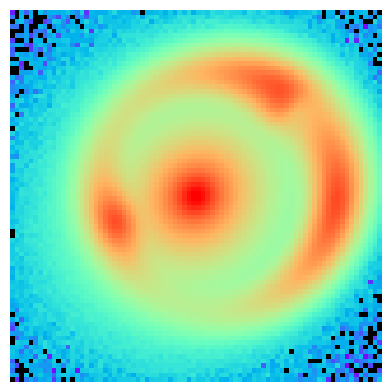

<Figure size 640x480 with 0 Axes>

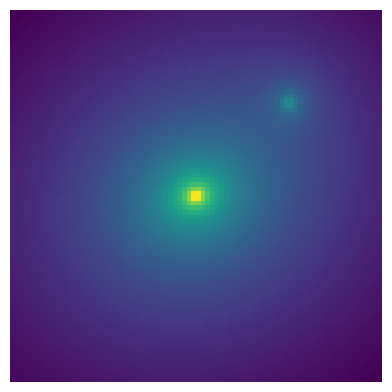

c: 45


In [194]:
# Cosmology and redshifts
z_lens = 0.5
z_source = 1.5
cosmo = cosmo  # or your custom cosmology

# Observation parameters
background_rms = 0.00215
exp_time = 25477.26
numPix = 80
deltaPix = 0.05
psf_type = 'PIXEL'

# PSF generation using realistic models
kernel_size = 91
# Point-source kernel: delta-function at center
kernel_point = np.zeros((kernel_size, kernel_size))
c = kernel_size // 2
kernel_point[c, c] = 1.
# Realistic Gaussian PSF kernel
sigma_pix = (fwhm / 2.355) / deltaPix
y, x = np.indices((kernel_size, kernel_size))
kernel_cut = np.exp(-0.5 * ((x - c)**2 + (y - c)**2) / sigma_pix**2)
# Normalize kernel
kernel_cut /= np.sum(kernel_cut)

# Data and PSF classes
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

kwargs_psf = {
    'psf_type': psf_type,
    'fwhm': fwhm,
    'pixel_size': deltaPix,
    'kernel_point_source': kernel_cut
}
psf_class = PSF(**kwargs_psf)
psf_point = PSF(psf_type=psf_type, fwhm=fwhm, pixel_size=deltaPix, kernel_point_source=kernel_point)

# Lens model setup
theta_E = 1.2
kwargs_sie = {'theta_E': theta_E, 'e1': 0.05, 'e2': 0.05, 'center_x': 0., 'center_y': 0.}
# Example NFW parameters (ensure alpha_Rs, Rs_angle defined)
alpha_Rs = 0.1
Rs_angle = 0.23
kwargs_nfw = {'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': 1., 'center_y': 1.}
lens_model_list = ['SIE', 'NFW']
kwargs_lens = [kwargs_sie, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# Source light model
theta, q = 0.5, 0.8
e1_src, e2_src = param_util.phi_q2_ellipticity(theta, q)
source_x, source_y = 0.3, 0.1
kwargs_sersic_source = {
    'amp': 4000,
    'R_sersic': 0.1,
    'n_sersic': 1.,
    'e1': e1_src,
    'e2': e2_src,
    'center_x': source_x,
    'center_y': source_y
}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)

# Lens light model
theta_l, q_l = 0.9, 0.9
e1_l, e2_l = param_util.phi_q2_ellipticity(theta_l, q_l)
kwargs_sersic_lens = {
    'amp': 8000,
    'R_sersic': 0.2,
    'n_sersic': 2.,
    'e1': e1_l,
    'e2': e2_l,
    'center_x': 0.,
    'center_y': 0.
}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# Numerics settings
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# Image simulation
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                        lens_light_model_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)

# Add Poisson noise and Gaussian background manually
#counts = image_sim * exp_time
#noisy_counts = np.random.poisson(counts)
#image_sim = noisy_counts.astype(float) / exp_time
#image_sim += np.random.normal(loc=0.0, scale=background_rms, size=image_sim.shape)

poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg     = image_util.add_background(image_sim, sigma_bkd=background_rms)

# Combine model and noise
image_sim = image_sim + poisson + bkg



# Update data class
data_class.update_data(image_sim)
# Display simulated image
cmap = plt.get_cmap('rainbow')
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')
v_min, v_max = -4, 2
plt.figure(figsize=(6, 6))
plt.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap)
plt.axis('off')
plt.show()

# Compute and display convergence (kappa)
from lenstronomy.Util import util
x_coords, y_coords = data_class.pixel_coordinates
kappa = lens_model_class.kappa(util.image2array(x_coords), util.image2array(y_coords), kwargs_lens)
plt.figure()
plt.matshow(util.array2image(np.log10(kappa)), origin='lower')
plt.axis('off')
plt.show()
print("c:",c)

In [196]:
####################
## Input mass and concentration
####################

Mpert = 10**11   #the mass of the subhalo
Cpert = 100  #the concentration of the halo

lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo) #cosmo=FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.725 K, Neff=3.046, m_nu=[0.  , 0.  , 0.06] eV, Ob0=0.0486)

Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=Mpert, c=Cpert)

print("Rs: ", Rs_angle, "angle: ", alpha_Rs)

Rs:  0.12954279662519458 angle:  0.2321325456990353


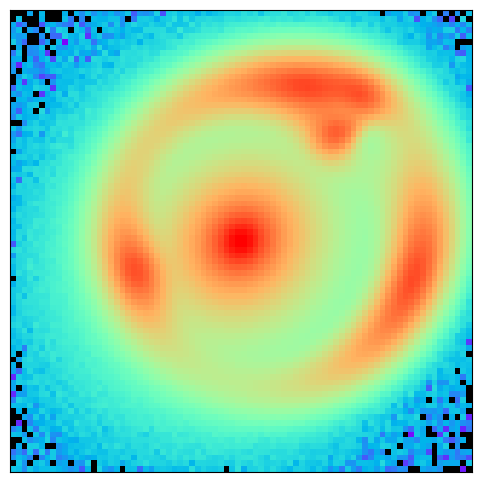

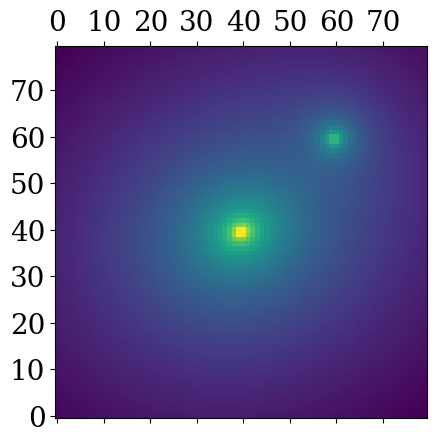

In [228]:
# 1) Cosmology & redshifts
z_lens, z_source = 0.5, 1.5
cosmo = cosmo

# 2) Observation parameters
background_rms = 0.00215  # per‑pixel sky noise (counts/sec)
exp_time = 25477.26  # seconds
numPix = 80  # cutout size (pixels)
deltaPix = 0.05 # arcsec/pixel
fwhm = 0.14  # arcsec
psf_type = 'PIXEL'

# 3) Load realistic TinyTim PSF
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, '212/tinypsf00.fits')
full_psf = pyfits.getdata(psf_filename)

# 4) Build PSF kernels
kernel_size = 91
# 4a) delta‑function for point sources
kernel_point = np.zeros((kernel_size, kernel_size))
c = kernel_size // 2
kernel_point[c, c] = 1.0
# 4b) Gaussian PSF approximation (for comparison or fallback)
sigma_pix = (fwhm / 2.355) / deltaPix
y, x = np.indices((kernel_size, kernel_size))
kernel_cut = np.exp(-0.5 * (((x - c)**2 + (y - c)**2) / sigma_pix**2))
kernel_cut /= np.sum(kernel_cut)

# 5) Data & PSF classes
kwargs_data = simulation_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

# GitHub‑style PSF definitions
kwargs_psf   = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
kwargs_point = {'psf_type': psf_type, 'pixel_size': deltaPix, 'kernel_point_source': kernel_point}
psf_class = PSF(**kwargs_psf)
psf_point = PSF(**kwargs_point)

# 6) Lens mass model
kwargs_sie = {
    'theta_E': 1.2,
    'e1': 0.05, 'e2': 0.05,
    'center_x': 0., 'center_y': 0.
}
kwargs_nfw = {
    'alpha_Rs': alpha_Rs,
    'Rs': Rs_angle,
    'center_x': 1., 'center_y': 1.
}
lens_model_list  = ['SIE', 'NFW']
kwargs_lens       = [kwargs_sie, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# 7) Source light model
e1_src, e2_src = param_util.phi_q2_ellipticity(0.5, 0.8)
kwargs_source = [{
    'amp': 4000,
    'R_sersic': 0.1,
    'n_sersic': 1.,
    'e1': e1_src,
    'e2': e2_src,
    'center_x': 0.3,
    'center_y': 0.1
}]
source_model_class = LightModel(light_model_list=['SERSIC_ELLIPSE'])

# 8) Lens light model
e1_l, e2_l = param_util.phi_q2_ellipticity(0.9, 0.9)
kwargs_lens_light = [{
    'amp': 8000,
    'R_sersic': 0.2,
    'n_sersic': 2.,
    'e1': e1_l,
    'e2': e2_l,
    'center_x': 0.,
    'center_y': 0.
}]
lens_light_model_class = LightModel(light_model_list=['SERSIC_ELLIPSE'])

# 9) Numerics
kwargs_numerics = {
    'supersampling_factor': 1,
    'supersampling_convolution': False
}

# Image simulation
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                        lens_light_model_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)

# 11) Add noise
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg     = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + poisson + bkg

# display the initial simulated image
cmap_string = 'rainbow'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4 #max and min of color scales: pixels at log_10 (v), where -4 is 10^-4
v_max = 2 #2 is 100

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

# and here we compute the convergence at each pixel position
x_coords, y_coords = data_class.pixel_coordinates
kappa = lens_model_class.kappa(util.image2array(x_coords), util.image2array(y_coords), kwargs_lens)
plt.matshow(util.array2image(np.log10(kappa)), origin='lower')
plt.show()

In [230]:
# Retry the calculation with available environment
from astropy.cosmology import Planck15 as cosmo
import numpy as np
from astropy.constants import c, G
import astropy.units as u

# given parameters
z_lens = 0.5
z_source = 1.5
theta_E_arcsec = 1.2  # Einstein radius in arcseconds

# calculate angular diameter distances
D_L = cosmo.angular_diameter_distance(z_lens)
D_S = cosmo.angular_diameter_distance(z_source)
D_LS = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

# Einstein radius in radians
theta_E_rad = np.deg2rad(theta_E_arcsec / 3600)

# Calculate lens mass using the lensing equation
mass_lens = (c**2 / (4 * G) * (D_L * D_S / D_LS) * theta_E_rad**2).to(u.Msun)

mass_lens


<Quantity 4.05465114e+11 solMass>